In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU
from keras.layers import BatchNormalization
from keras.utils import np_utils
#from keras.engine import Merge
from keras.layers import TimeDistributed, Lambda
from keras.layers import Convolution1D, GlobalMaxPooling1D
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.layers.advanced_activations import PReLU
from keras.preprocessing import sequence, text

In [2]:
!wget https://ml.azure.com/fileexplorerAzNB?wsid=/subscriptions/8ed3e7d5-c78d-49cb-ad0a-46c3a5f6d9a6/resourcegroups/WD/workspaces/wheatDetection&tid=15bfb374-e29e-4015-ad22-1ac402610644&activeFilePath=Users/akshaychacharkar27/LSTM_Quara/EmbeddingsMatrix.npy

In [3]:
!unzip ../input/quora-question-pairs/train.csv.zip

Archive:  ../input/quora-question-pairs/train.csv.zip
  inflating: train.csv               


In [4]:
!unzip ../input/quora-question-pairs/test.csv.zip

Archive:  ../input/quora-question-pairs/test.csv.zip
  inflating: test.csv                


In [5]:
data = pd.read_csv('./train.csv')
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
data_test = pd.read_csv('./test.csv')
data_test.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
y = data.is_duplicate.values

In [8]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
tk = text.Tokenizer(num_words=200000)

max_len = 40
tk.fit_on_texts(list(data.question1.values.astype(str)) + list(data.question2.values.astype(str)))
x1 = tk.texts_to_sequences(data.question1.values.astype(str))
x1 = sequence.pad_sequences(x1, maxlen=max_len)

In [10]:
x2 = tk.texts_to_sequences(data.question2.values.astype(str))
x2 = sequence.pad_sequences(x2, maxlen=max_len)

In [11]:
!wget https://nlp.stanford.edu/data/glove.42B.300d.zip

--2022-03-27 10:44:37--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2022-03-27 10:44:37--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Saving to: ‘glove.42B.300d.zip’

glove.42B.300d.zip  100%[===================>]   1.75G  5.02MB/s    in 5m 54s  

2022-03-27 10:50:31 (5.05 MB/s) - ‘glove.42B.300d.zip’ saved [1877800501/1877800501]



In [12]:
!unzip ./glove.42B.300d.zip

Archive:  ./glove.42B.300d.zip
  inflating: glove.42B.300d.txt      


In [13]:
ytrain_enc = np_utils.to_categorical(y)

In [14]:
ytrain_enc

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [15]:
word_index = tk.word_index

In [16]:
embeddings_index = {}
f = open('./glove.42B.300d.txt')
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

1917494it [02:44, 11626.92it/s]

Found 1917494 word vectors.


In [17]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 95596/95596 [00:00<00:00, 249177.77it/s]


In [18]:
max_features = 200000
filter_length = 5
nb_filter = 64
pool_length = 4

In [19]:
print('Build model...')

Build model...


In [20]:
import tensorflow as tf
from keras.layers import TimeDistributed,Lambda
from keras.layers.core import Dense, Activation, Dropout,Flatten
from keras.regularizers import l2
from keras.layers.embeddings import Embedding
from keras.layers import Input,BatchNormalization
from keras.layers import Conv1D, MaxPool1D
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler
import os
import datetime
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.layers import concatenate

In [21]:
input_1 = Input(shape=(max_len,),name = 'Input_1')
embedding_1 = Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False,
                            name = 'embedding_1')
embedded_sequences_1 = embedding_1(input_1)
timedist_1 = TimeDistributed(Dense(300, activation='relu'))(embedded_sequences_1)
lambdalayer_1 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(timedist_1)
model_1 = Model(inputs=input_1,outputs=lambdalayer_1)

2022-03-27 10:54:15.329930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 10:54:15.421190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 10:54:15.421963: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-27 10:54:15.423543: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [22]:
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 300)           28679100  
_________________________________________________________________
time_distributed (TimeDistri (None, 40, 300)           90300     
_________________________________________________________________
lambda (Lambda)              (None, 300)               0         
Total params: 28,769,400
Trainable params: 90,300
Non-trainable params: 28,679,100
_________________________________________________________________


In [23]:
input_2 = Input(shape=(max_len,),name = 'Input_2')
embedding_2 = Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False,
                            name = 'embedding_2')
embedded_sequences_2 = embedding_2(input_2)
timedist_2 = TimeDistributed(Dense(300, activation='relu'))(embedded_sequences_2)
lambdalayer_2 = Lambda(lambda x: K.sum(x, axis=1), output_shape=(300,))(timedist_2)
model_2 = Model(inputs=input_2,outputs=lambdalayer_2)

2022-03-27 10:54:20.938962: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114716400 exceeds 10% of free system memory.


In [24]:
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 300)           28679100  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 300)           90300     
_________________________________________________________________
lambda_1 (Lambda)            (None, 300)               0         
Total params: 28,769,400
Trainable params: 90,300
Non-trainable params: 28,679,100
_________________________________________________________________


In [25]:
input_3 = Input(shape=(max_len,),name = 'Input_3')
embedding_3 = Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False,
                            name = 'embedding_3')(input_3)

Conv1D_L1_p = Conv1D(filters=nb_filter,kernel_size=filter_length,strides=1,padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30)
                                            ,kernel_regularizer=l2(0.00001),
                                            name='Conv1D_L1_p')(embedding_3)
drop_1 =Dropout(0.2)(Conv1D_L1_p)


Conv1D_L2_p = Conv1D(filters=nb_filter,kernel_size=filter_length,strides=1,padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30)
                                            ,kernel_regularizer=l2(0.00001),
                                            name='Conv1D_L2_p')(drop_1)

Pool_Max_1 = tf.keras.layers.GlobalMaxPooling1D()(Conv1D_L2_p)
drop_2 =Dropout(0.2)(Pool_Max_1)

DnsL_1 = Dense(300,activation='relu',
             kernel_initializer=tf.keras.initializers.he_normal(seed=30),
             kernel_regularizer=l2(0.001))(drop_2)
drop_3 =Dropout(0.2)(DnsL_1)
batch_N=BatchNormalization()(drop_3)
model_3 = Model(inputs=input_3,outputs=batch_N)

2022-03-27 10:54:24.140949: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114716400 exceeds 10% of free system memory.


In [26]:
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 300)           28679100  
_________________________________________________________________
Conv1D_L1_p (Conv1D)         (None, 40, 64)            96064     
_________________________________________________________________
dropout (Dropout)            (None, 40, 64)            0         
_________________________________________________________________
Conv1D_L2_p (Conv1D)         (None, 40, 64)            20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0   

In [27]:
input_4 = Input(shape=(max_len,),name = 'Input_4')
embedding_4 = Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,trainable=False,
                            name = 'embedding_4')(input_4)

Conv1D_L1_p4 = Conv1D(filters=nb_filter,kernel_size=filter_length,strides=1,padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30)
                                            ,kernel_regularizer=l2(0.00001),
                                            name='Conv1D_L1_p4')(embedding_4)
drop_1_4 =Dropout(0.2)(Conv1D_L1_p4)


Conv1D_L2_p4 = Conv1D(filters=nb_filter,kernel_size=filter_length,strides=1,padding='same',data_format='channels_last',
              activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30)
                                            ,kernel_regularizer=l2(0.00001),
                                            name='Conv1D_L2_p4')(drop_1_4)

Pool_Max_1_4 = tf.keras.layers.GlobalMaxPooling1D()(Conv1D_L2_p4)
drop_2_4 =Dropout(0.2)(Pool_Max_1_4)

DnsL_1_4 = Dense(300,activation='relu',
             kernel_initializer=tf.keras.initializers.he_normal(seed=30),
             kernel_regularizer=l2(0.001))(drop_2_4)
drop_3_4 = Dropout(0.2)(DnsL_1_4)
batch_N_4 = BatchNormalization()(drop_3_4)
model_4 = Model(inputs=input_4,outputs=batch_N_4)

2022-03-27 10:54:27.632293: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114716400 exceeds 10% of free system memory.


In [28]:
model_4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_4 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 40, 300)           28679100  
_________________________________________________________________
Conv1D_L1_p4 (Conv1D)        (None, 40, 64)            96064     
_________________________________________________________________
dropout_3 (Dropout)          (None, 40, 64)            0         
_________________________________________________________________
Conv1D_L2_p4 (Conv1D)        (None, 40, 64)            20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0   

In [29]:
Input_LSTM_1 = Input(shape=(max_len,),name = 'Input_LSTM_1')
embedding_Q1 = Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,
                         trainable=False,name = 'embedding_Q1')(Input_LSTM_1)
drop_5_1 =Dropout(0.2)(embedding_Q1)
LSTM_Q1 = LSTM(name='LSTM_Q1', units=300,dropout = 0.2,recurrent_dropout=0.2)(drop_5_1)
model_5 = Model(inputs=Input_LSTM_1,outputs=LSTM_Q1)

2022-03-27 10:54:30.901692: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 114716400 exceeds 10% of free system memory.


In [30]:
model_5.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_LSTM_1 (InputLayer)    [(None, 40)]              0         
_________________________________________________________________
embedding_Q1 (Embedding)     (None, 40, 300)           28679100  
_________________________________________________________________
dropout_6 (Dropout)          (None, 40, 300)           0         
_________________________________________________________________
LSTM_Q1 (LSTM)               (None, 300)               721200    
Total params: 29,400,300
Trainable params: 721,200
Non-trainable params: 28,679,100
_________________________________________________________________


In [31]:
Input_LSTM_2 = Input(shape=(max_len,),name = 'Input_LSTM_2')
embedding_Q2 = Embedding(len(word_index) + 1,300,weights=[embedding_matrix],input_length=max_len,
                         trainable=False,name = 'embedding_Q2')(Input_LSTM_2)
drop_6_1 =Dropout(0.2)(embedding_Q2)
LSTM_Q2 = LSTM(name='LSTM_Q2', units=300,dropout = 0.2,recurrent_dropout=0.2)(drop_6_1)
model_6 = Model(inputs=Input_LSTM_2,outputs=LSTM_Q2)

In [32]:
model_6.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_LSTM_2 (InputLayer)    [(None, 40)]              0         
_________________________________________________________________
embedding_Q2 (Embedding)     (None, 40, 300)           28679100  
_________________________________________________________________
dropout_7 (Dropout)          (None, 40, 300)           0         
_________________________________________________________________
LSTM_Q2 (LSTM)               (None, 300)               721200    
Total params: 29,400,300
Trainable params: 721,200
Non-trainable params: 28,679,100
_________________________________________________________________


In [33]:
merged_layers = concatenate([model_1.output,model_2.output,model_3.output,model_4.output,
                                                    model_5.output,model_6.output])
x = BatchNormalization()(merged_layers)

In [34]:
dnsl_f = Dense(300)(x)
prelu_f = PReLU()(dnsl_f)
dropout_f = Dropout(0.2)(prelu_f)
bn_f = BatchNormalization()(dropout_f)
#x = Dense(2)(x)
#out = Activation('softmax')(x)
out = Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=3),name='Output')(bn_f)

In [35]:
merged_model = Model([model_1.input, model_2.input, model_3.input,
                      model_4.input, model_5.input, model_6.input], [out])

In [36]:
optimizer=tf.keras.optimizers.Adam(learning_rate=0.01)
merged_model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
filepath= "best_model.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=2, save_best_only=True, mode='auto')

In [37]:
merged_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_3 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
Input_4 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 40, 300)      28679100    Input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 40, 300)      28679100    Input_4[0][0]                    
____________________________________________________________________________________________

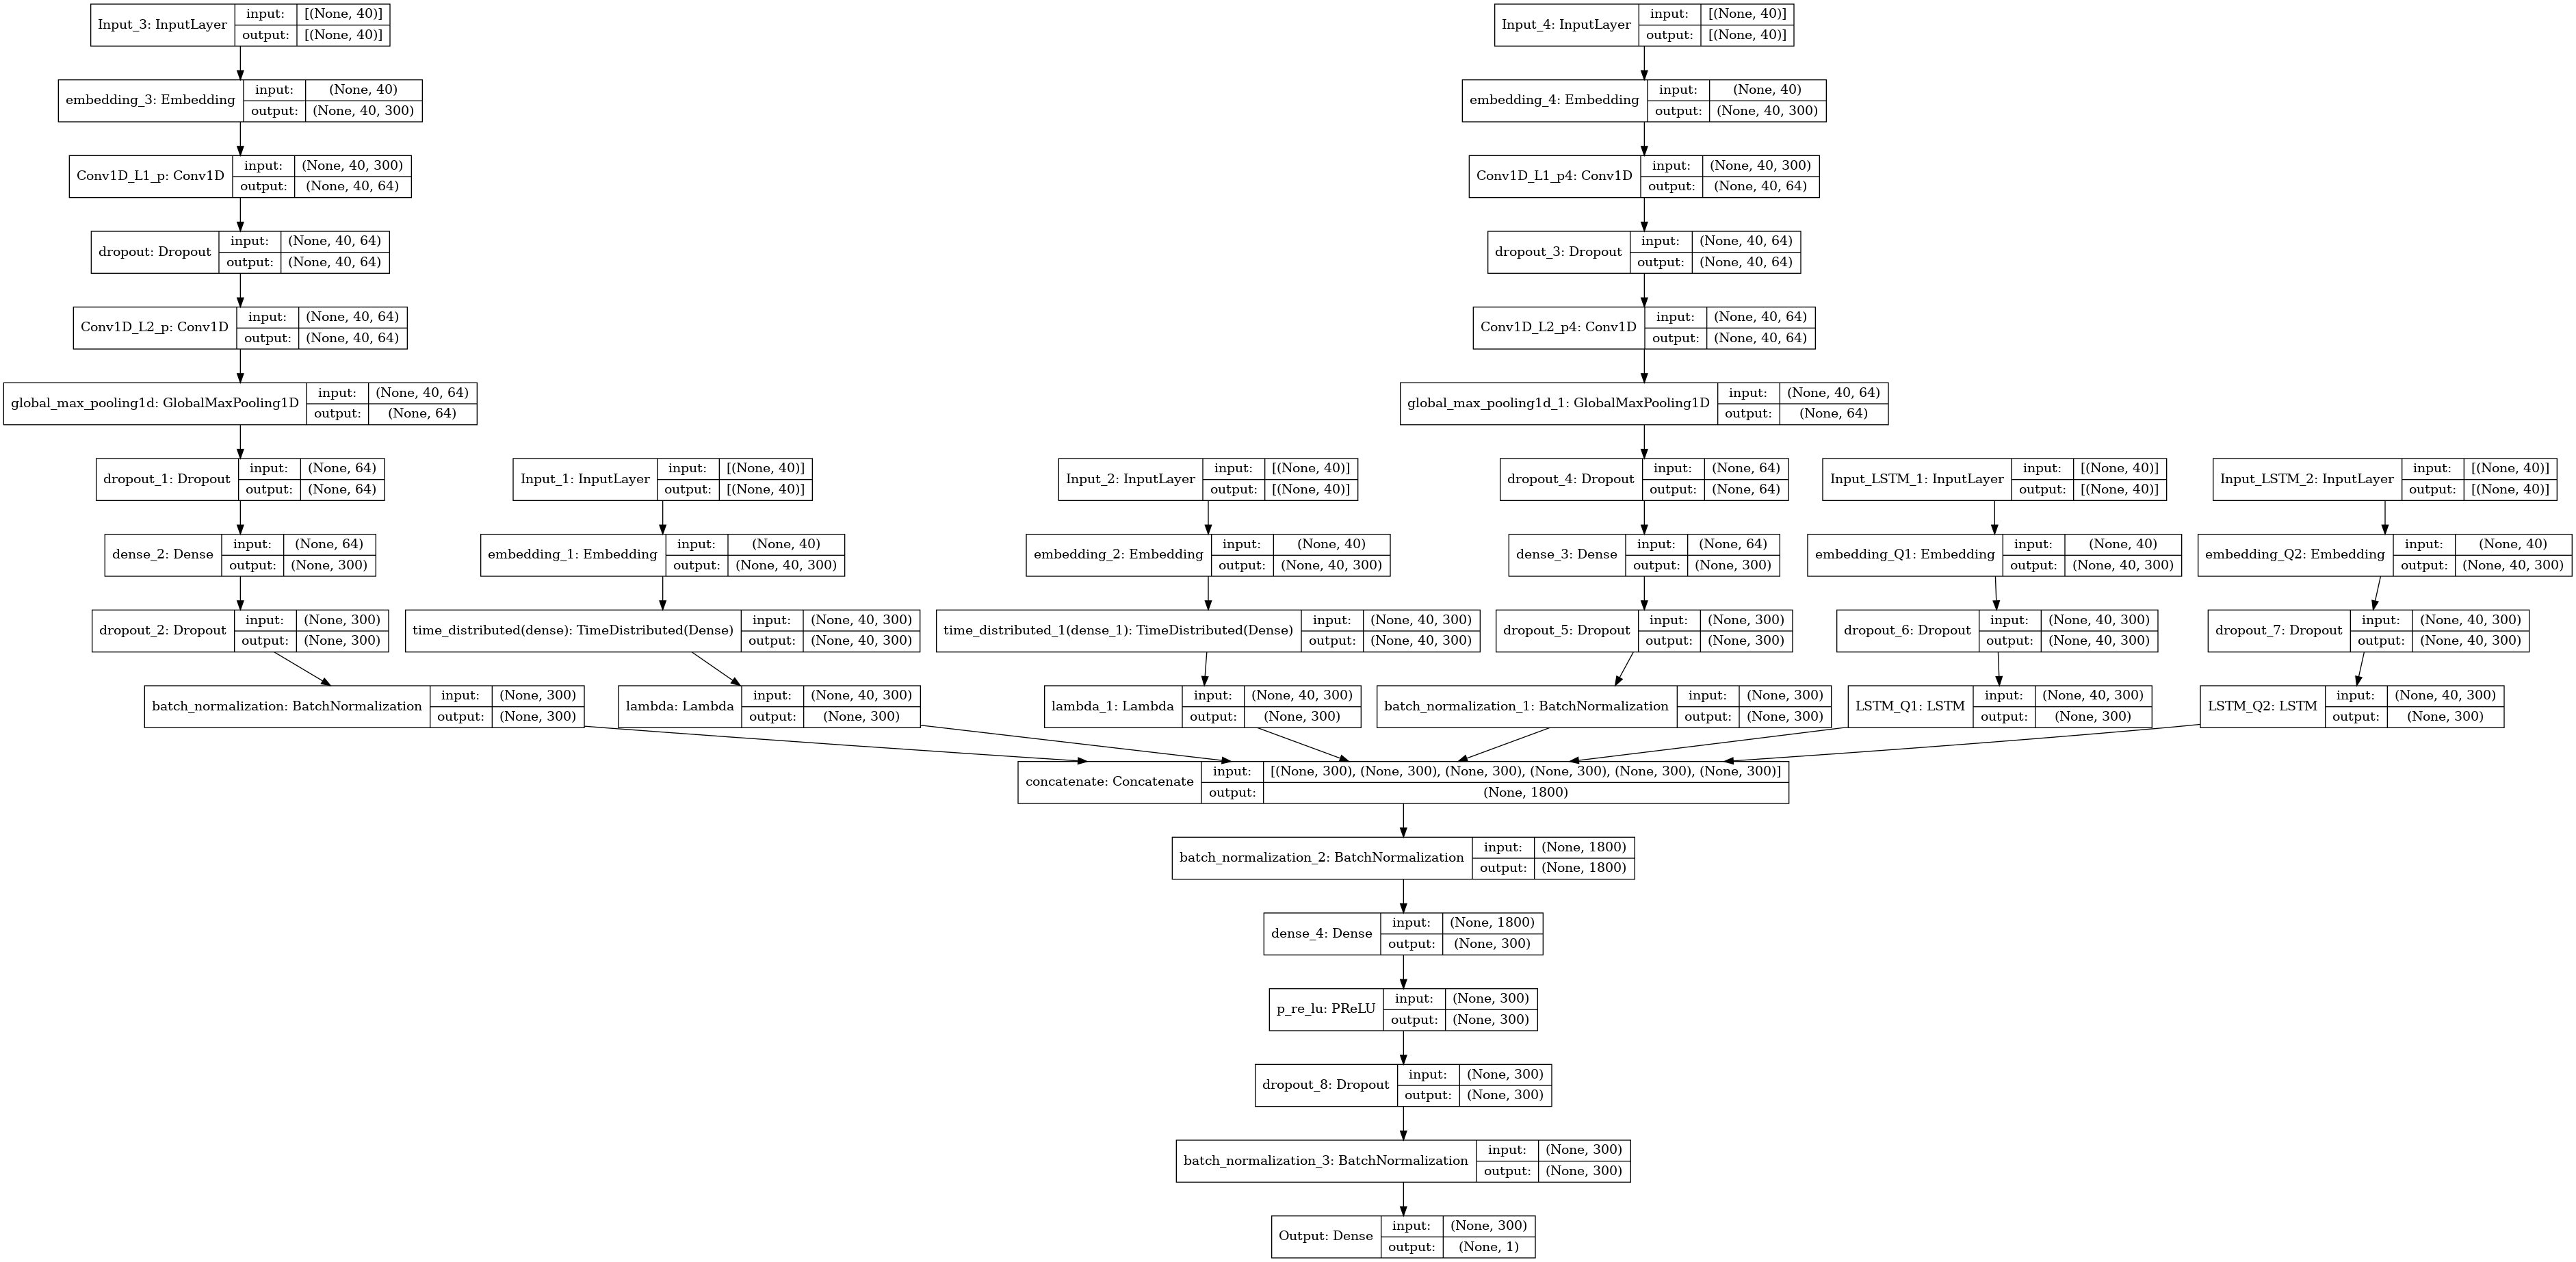

In [38]:
from tensorflow.keras.utils import plot_model
plot_model(merged_model, 'merged_model.png', show_shapes=True)

In [39]:
log_dir = os.path.join("logs1",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

merged_model.fit([x1, x2, x1, x2, x1, x2],
                 y=y,epochs=50,batch_size=384,
                 verbose=1, validation_split=0.1, shuffle=True,
                 callbacks=[checkpoint,tensorboard_callback])

2022-03-27 10:54:48.649039: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-27 10:54:48.649086: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-03-27 10:54:48.652158: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-03-27 10:54:49.048867: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-27 10:54:49.049100: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-27 10:54:49.588274: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-03-27 10:54:59.298566: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/948 [..............................] - ETA: 3:48:23 - loss: 2.1187 - accuracy: 0.5026

2022-03-27 10:55:04.444337: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-03-27 10:55:04.444391: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/948 [..............................] - ETA: 23:34 - loss: 2.6953 - accuracy: 0.5378  

2022-03-27 10:55:05.631873: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-03-27 10:55:05.651778: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-03-27 10:55:05.972516: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 19554 callback api events and 19551 activity events. 
2022-03-27 10:55:06.443961: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-03-27 10:55:07.328065: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs1/fits/20220327-105448/train/plugins/profile/2022_03_27_10_55_06

2022-03-27 10:55:07.821149: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs1/fits/20220327-105448/train/plugins/profile/2022_03_27_10_55_06/ee6a43626f4b.trace.json.gz
2022-03-27 10:55:08.401370: I tensorflow/core/profiler/rpc/client/save_pro

948/948 [==============================] - 522s 536ms/step - loss: 0.5671 - accuracy: 0.7417 - val_loss: 0.4809 - val_accuracy: 0.7706

Epoch 00001: val_accuracy improved from -inf to 0.77061, saving model to best_model.h5
Epoch 2/50
948/948 [==============================] - 539s 568ms/step - loss: 0.4601 - accuracy: 0.7786 - val_loss: 0.4363 - val_accuracy: 0.7892

Epoch 00002: val_accuracy improved from 0.77061 to 0.78916, saving model to best_model.h5
Epoch 3/50
948/948 [==============================] - 502s 529ms/step - loss: 0.4258 - accuracy: 0.7967 - val_loss: 0.4138 - val_accuracy: 0.7996

Epoch 00003: val_accuracy improved from 0.78916 to 0.79957, saving model to best_model.h5
Epoch 4/50
948/948 [==============================] - 499s 527ms/step - loss: 0.4020 - accuracy: 0.8089 - val_loss: 0.4044 - val_accuracy: 0.8076

Epoch 00004: val_accuracy improved from 0.79957 to 0.80759, saving model to best_model.h5
Epoch 5/50
948/948 [==============================] - 518s 546ms/s

In [40]:
merged_model.save("LSTM_Quara.h5")